In [2]:
import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import platform
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.4-arm64-arm-64bit
Tensor Flow Version: 2.12.0
Keras Version: 2.12.0

Python 3.10.9 (main, Mar  1 2023, 12:20:14) [Clang 14.0.6 ]
Pandas 2.0.3
Scikit-Learn 1.3.0
SciPy 1.11.1
GPU is available


**Based on the paper** :https://arxiv.org/pdf/1612.05251.pdf:
 *2017 paper PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts.*

In [5]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md
helper_functions.py


In [6]:
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/

dev.txt   test.txt  train.txt train.zip


In [8]:
data_dir="pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [9]:
import os
filenames= [data_dir+ filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [10]:
def get_lines(filename):
    with open(filename) as f:
        return f.readlines()

In [11]:
train_lines=get_lines(data_dir+'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [12]:
len(train_lines)

210040

# Data Representation

[{ line number:0
   text:
   target:Background
   total_lines:11
   }]

In [13]:
def pre_processing_data(filename):
    input_lines=get_lines(filename)
    abstract_lines=""
    abstract_samples=[]
    
    for line in input_lines:
        if line.startswith("###"):
            abstract_id=line
            abstract_lines=""
        elif line.isspace():
            abstract_line_split=abstract_lines.splitlines()
            for abstract_line_number,abstract_line in enumerate(abstract_line_split):
                line_data={}
                target_split=abstract_line.split("\t")
                line_data["target"]=target_split[0]
                line_data["text"]=target_split[1].lower()
                line_data["line_number"]=abstract_line_number
                line_data["total_lines"]=len(abstract_line_split)-1
                abstract_samples.append(line_data)
        else:
            abstract_lines+=line
    return abstract_samples

In [14]:
%%time
train_samples= pre_processing_data(data_dir+"train.txt")
val_samples=pre_processing_data(data_dir+"dev.txt")
test_samples=pre_processing_data(data_dir+"test.txt")

CPU times: user 301 ms, sys: 47.9 ms, total: 349 ms
Wall time: 359 ms


In [15]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [16]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)

In [17]:
train_df.head(14)

target                                               text  \
0     OBJECTIVE  to investigate the efficacy of @ weeks of dail...   
1       METHODS  a total of @ patients with primary knee oa wer...   
2       METHODS  outcome measures included pain reduction and i...   
3       METHODS  pain was assessed using the visual analog pain...   
4       METHODS  secondary outcome measures included the wester...   
5       METHODS  serum levels of interleukin @ ( il-@ ) , il-@ ...   
6       RESULTS  there was a clinically relevant reduction in t...   
7       RESULTS  the mean difference between treatment arms ( @...   
8       RESULTS  further , there was a clinically relevant redu...   
9       RESULTS  these differences remained significant at @ we...   
10      RESULTS  the outcome measures in rheumatology clinical ...   
11  CONCLUSIONS  low-dose oral prednisolone had both a short-te...   
12   BACKGROUND  emotional eating is associated with overeating...   
13   BACKGROUND  yet , empirical evidence for individual ( trai...   

    line_number  total_lines  
0             0           11  
1             1           11  
2             2           11  
3             3           11  
4             4           11  
5             5           11  
6             6           11  
7             7           11  
8             8           11  
9             9           11  
10           10           11  
11           11           11  
12            0           10  
13            1           10

In [18]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

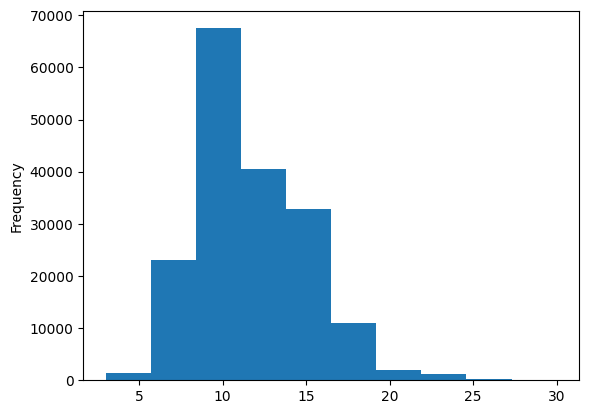

In [19]:
train_df.total_lines.plot.hist()

In [20]:
train_sentences=train_df['text'].tolist()
val_sentences=val_df['text'].tolist()
test_sentences=test_df['text'].tolist()

In [21]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# Text to numbers 

In [22]:
#one hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse_output=False)
train_labels_one_hot=one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_label_one_hot=one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))


In [23]:
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [44]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
train_labels_encoder=labelencoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoder=labelencoder.transform(val_df["target"].to_numpy())
test_label_encoder=labelencoder.transform(test_df["target"].to_numpy())


In [24]:
train_labels_encoder

array([3, 2, 2, ..., 4, 1, 1])

In [25]:
class_names=labelencoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

# Model 0

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0= Pipeline (
[
    ("Tdidf", TfidfVectorizer()),
    ("Naive-bayes(classification)", MultinomialNB())
])


In [27]:
model_0.fit(train_sentences,train_labels_encoder)

Pipeline(steps=[('Tdidf', TfidfVectorizer()),
                ('Naive-bayes(classification)', MultinomialNB())])

In [28]:
model_0.score(val_sentences,val_labels_encoder)

0.7218323844829869

In [29]:
baseline_preds=model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [30]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
def calculate_results(y_true,y_pred):
    model_accuracy=accuracy_score(y_true,y_pred)*100
    model_precision,recall_score,f1_score, _ = precision_recall_fscore_support(y_true,y_pred,average="weighted")
    #Compute precision, recall, F-measure and support for each class.
    results={ "accuracy":model_accuracy,
               "precision":model_precision*100,
               "recall":recall_score*100,
               "F1-score":f1_score*100}
    return results



In [31]:
model_0_reults=calculate_results(val_labels_encoder,baseline_preds)

In [32]:
model_0_reults

{'accuracy': 72.1832384482987,
 'precision': 71.86466952323352,
 'recall': 72.1832384482987,
 'F1-score': 69.89250353450294}

# Model-1 Conv1D with token embeddings

In [33]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
tokenize=TextVectorization(max_tokens=None,standardize='lower_and_strip_punctuation',
                           ngrams=None,
                           output_mode='int',
                           output_sequence_length=None
)

In [34]:
train_sentences[0].split()

['to',
 'investigate',
 'the',
 'efficacy',
 'of',
 '@',
 'weeks',
 'of',
 'daily',
 'low-dose',
 'oral',
 'prednisolone',
 'in',
 'improving',
 'pain',
 ',',
 'mobility',
 ',',
 'and',
 'systemic',
 'low-grade',
 'inflammation',
 'in',
 'the',
 'short',
 'term',
 'and',
 'whether',
 'the',
 'effect',
 'would',
 'be',
 'sustained',
 'at',
 '@',
 'weeks',
 'in',
 'older',
 'adults',
 'with',
 'moderate',
 'to',
 'severe',
 'knee',
 'osteoarthritis',
 '(',
 'oa',
 ')',
 '.']

In [35]:
a=0
for i in train_sentences:
    a=a+(len(i.split()))
    

In [36]:
avg_no_words=round(a/len(train_sentences))
avg_no_words

26

In [37]:
import numpy as np

In [38]:
lenghts=[len(sentence.split()) for sentence in train_sentences]
avg=np.mean(lenghts)
max(lenghts),avg

(296, 26.338269273494777)

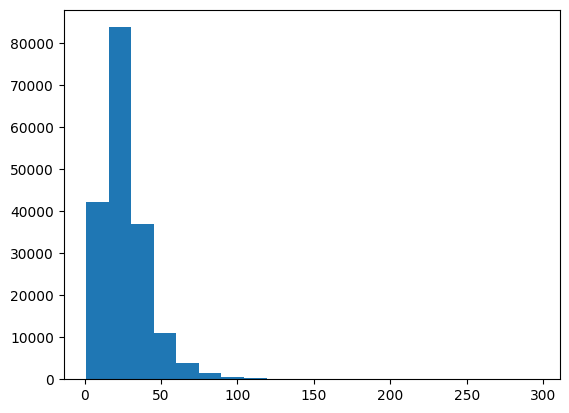

In [39]:
import matplotlib.pyplot as plt
plt.hist(lenghts,bins=20);

In [40]:
# what sentence length covers 95% of the samples
percentile=np.percentile(lenghts,95)
percentile

55.0

In [41]:
# 55 sentence length is the highest
max_vocab_words=64000
max_length=55
text_tokenize=TextVectorization(
                        max_tokens=max_vocab_words,
                        output_mode='int',
                        output_sequence_length=max_length
        )

In [42]:
text_tokenize.adapt(train_sentences)

2023-06-13 17:41:34.825717: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [43]:
import random
random_sentence=random.choice(train_sentences)
print(f"Original sentence {random_sentence}\n")
print(f"lengh of text {len (random_sentence.split())}\n")
print(f"Vectorized text {text_tokenize([random_sentence])}")

Original sentence use of a diclofenac sodium suppository ( @mg ) was allowed for all patients at any time after surgery , and the diclofenac sodium suppository usage was assessed .

lengh of text 29

Vectorized text [[  87    4    8 2868  764 6735   68   10 2583   11   62   12   15  262
    63   21  115    3    2 2868  764 6735 2637   10  113    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [44]:
text_vocab=text_tokenize.get_vocabulary()
print(f"Number of words in vocab { len(text_vocab)}")
print (f"Top 5  most frquent words {text_vocab[:5]}")
print (f"Top 5 least frquent words {text_vocab[-5:]}")


Number of words in vocab 64000
Top 5  most frquent words ['', '[UNK]', 'the', 'and', 'of']
Top 5 least frquent words ['andbehavior', 'andat', 'andapplication', 'ancovamean', 'ancovaadjusted']


In [45]:
text_tokenize.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 64000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64000}

In [46]:
token_embedding=tf.keras.layers.Embedding(input_dim=len(text_vocab),
                                         output_dim=128,
                                          mask_zero=False
)

In [47]:
print(f"Original sentence {random_sentence}\n")
print(f"Vectorized sentence {text_tokenize([random_sentence])}\n")
print(f"Embedded sentence {token_embedding(text_tokenize([random_sentence]))}")
print(f"Embedded sentence shape: {token_embedding(text_tokenize([random_sentence])).shape}")


Original sentence use of a diclofenac sodium suppository ( @mg ) was allowed for all patients at any time after surgery , and the diclofenac sodium suppository usage was assessed .

Vectorized sentence [[  87    4    8 2868  764 6735   68   10 2583   11   62   12   15  262
    63   21  115    3    2 2868  764 6735 2637   10  113    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Embedded sentence [[[ 0.04358969  0.00608678 -0.02475305 ...  0.02248098 -0.00060068
   -0.02649772]
  [ 0.01575196 -0.01732622 -0.03623853 ...  0.04600047  0.02817501
    0.01843751]
  [ 0.02404206 -0.04182126  0.01860196 ... -0.02644104  0.04451705
    0.03283714]
  ...
  [ 0.02993966 -0.0383271   0.00891661 ...  0.04420439 -0.01741441
   -0.01684239]
  [ 0.02993966 -0.0383271   0.00891661 ...  0.04420439 -0.01741441
   -0.01684239]
  [ 0.02993966 -0.0383271   0.00891661 ...  0.04420439 -0.01741441
   -0.

The tf.data.Dataset.from_tensor_slices() function is a utility in TensorFlow that creates a tf.data.Dataset object from one or more input tensors. This function is particularly useful for creating an input pipeline for training or inference tasks. 

In [48]:
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
val_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_label_one_hot))

In [49]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [50]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [51]:
inputs=tf.keras.layers.Input(shape=(1,), dtype="string")
text_vector=text_tokenize(inputs)
text_embedding=token_embedding(text_vector)
x=tf.keras.layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(text_embedding)
x=tf.keras.layers.GlobalAveragePooling1D()(x)
outputs=tf.keras.layers.Dense(len(class_names),activation="softmax")(x)
model_1=tf.keras.Model(inputs,outputs)

In [52]:
model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"])
     

In [53]:
model_1.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 55, 128)           8192000   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [54]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 27s 47ms/step - loss: 0.9223 - accuracy: 0.6340 - val_loss: 0.6906 - val_accuracy: 0.7307
Epoch 2/3
562/562 [==============================] - 24s 44ms/step - loss: 0.6571 - accuracy: 0.7563 - val_loss: 0.6362 - val_accuracy: 0.7689
Epoch 3/3
562/562 [==============================] - 27s 48ms/step - loss: 0.6151 - accuracy: 0.7751 - val_loss: 0.5962 - val_accuracy: 0.7836


In [56]:
model_probs=model_1.predict(val_dataset)
model_probs

945/945 [==============================] - 2s 2ms/step


array([[4.7636923e-01, 1.2716618e-01, 5.3757947e-02, 3.2397968e-01,
        1.8726962e-02],
       [3.8611493e-01, 3.2393026e-01, 1.3540406e-02, 2.6583520e-01,
        1.0579119e-02],
       [1.3623297e-01, 6.9641406e-03, 1.8214269e-03, 8.5494816e-01,
        3.3247936e-05],
       ...,
       [1.3169743e-05, 6.1650638e-04, 8.4461336e-04, 5.1141324e-06,
        9.9852055e-01],
       [5.5400979e-02, 4.4984341e-01, 8.8301055e-02, 7.4640714e-02,
        3.3181381e-01],
       [1.5156463e-01, 7.0157272e-01, 4.8869491e-02, 4.7299001e-02,
        5.0694138e-02]], dtype=float32)

In [57]:
model_1_pred=tf.argmax(model_probs,axis=1)
model_1_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [58]:
model_1_results=calculate_results(val_labels_encoder,model_1_pred)

In [59]:
model_1_results

{'accuracy': 78.7104461803257,
 'precision': 78.3333456187092,
 'recall': 78.7104461803257,
 'F1-score': 78.41304194274046}

In [60]:
# Model-2 Using Pretrained Model
import tensorflow_hub as hub
tf_hub_embedding_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                      trainable=False)

In [36]:
import random
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")
     

Random training sentence:
missing data were imputed using multiple imputation .



NameError: name 'tf_hub_embedding_layer' is not defined

In [62]:
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
pre_trained_embedding=tf_hub_embedding_layer(inputs)
x=tf.keras.layers.Dense(128,activation="relu")(pre_trained_embedding)
outputs=tf.keras.layers.Dense(len(class_names),activation="softmax")(x)
model_2=tf.keras.Model(inputs,outputs)

In [63]:
model_2.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [64]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"])

In [65]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=val_dataset,
            validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 49s 86ms/step - loss: 0.9129 - accuracy: 0.6509 - val_loss: 0.7937 - val_accuracy: 0.6912
Epoch 2/3
562/562 [==============================] - 45s 80ms/step - loss: 0.7674 - accuracy: 0.7020 - val_loss: 0.7538 - val_accuracy: 0.7061
Epoch 3/3
562/562 [==============================] - 61s 109ms/step - loss: 0.7503 - accuracy: 0.7122 - val_loss: 0.7382 - val_accuracy: 0.7131


In [66]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

945/945 [==============================] - 82s 86ms/step


array([[4.4031423e-01, 3.4722412e-01, 2.5081097e-03, 1.9981924e-01,
        1.0134370e-02],
       [3.3964318e-01, 4.9833187e-01, 3.6500413e-03, 1.5515944e-01,
        3.2154536e-03],
       [2.6505971e-01, 1.5719941e-01, 1.9075207e-02, 5.1727098e-01,
        4.1394755e-02],
       ...,
       [1.8576552e-03, 6.5741059e-03, 5.2557763e-02, 9.0209109e-04,
        9.3810833e-01],
       [4.2318460e-03, 4.7142524e-02, 1.9696368e-01, 1.3423875e-03,
        7.5031954e-01],
       [1.6839372e-01, 2.3914343e-01, 5.2446765e-01, 5.4206112e-03,
        6.2574625e-02]], dtype=float32)

In [68]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [69]:
model_2_results = calculate_results(val_labels_encoder,
                                    model_2_preds)
model_2_results
     

{'accuracy': 71.39216205481266,
 'precision': 71.42823673632186,
 'recall': 71.39216205481266,
 'F1-score': 71.10159521803406}

# model 3-conv 1D using character embeddings


In [70]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [35]:
def split_to_char(text):
    return " " .join(list(text))

split_to_char(random_training_sentence)

NameError: name 'random_training_sentence' is not defined

In [72]:
train_chars=[split_to_char(sentence) for sentence in train_sentences]
val_chars=[split_to_char(sentence) for sentence in val_sentences]
test_chars=[split_to_char(sentence) for sentence in test_sentences]

In [73]:
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [74]:
char_length=[len(sentence) for sentence in train_sentences]
mean_length=np.mean(char_length)
mean_length,

(149.3662574983337,)

In [75]:
char_percentile =np.percentile(char_length,95)

In [76]:
char_percentile # most characters are 290 or less

290.0

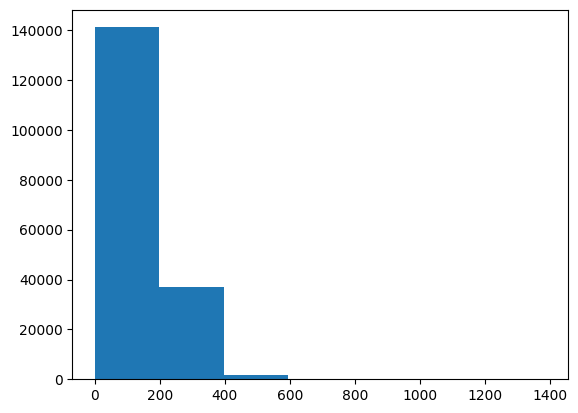

In [77]:
plt.hist(char_length,bins=7);

In [78]:
import string
alphabet= string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [79]:
max_length_tokens=len(alphabet)+2
char_vectorization=TextVectorization( 
                max_tokens=max_length_tokens,
               output_mode='int',
                output_sequence_length=int(char_percentile)
            )

In [80]:
char_vectorization.adapt(train_chars)

In [81]:
char_vocab=char_vectorization.get_vocabulary()

In [82]:
char_vocab[:10]

['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's']

In [83]:
char_embedding=tf.keras.layers.Embedding(input_dim=max_length_tokens,
                                         output_dim=25,
                                         mask_zero=None
)

In [85]:
random_char=random.choice(train_chars)
print(f"Original text: \n {random_char}\n")
print(f"Vectorized Text {char_vectorization([random_char])}\n")
char_embed=char_embedding(char_vectorization([random_char]))
print(f"Embedded Text {char_embed}")
print(char_embed.shape)

Original text: 
 p a r e c o x i b   s o d i u m   a n a l g e s i a   r e d u c e s   t h e   r a t e   o f   p o d   a n d   p o c d   i n   e l d e r l y   p a t i e n t s   w i t h   n e u r o p r o t e c t i v e   e f f e c t s   .

Vectorized Text [[14  5  8  2 11  7 24  4 22  9  7 10  4 16 15  5  6  5 12 18  2  9  4  5
   8  2 10 16 11  2  9  3 13  2  8  5  3  2  7 17 14  7 10  5  6 10 14  7
  11 10  4  6  2 12 10  2  8 12 19 14  5  3  4  2  6  3  9 20  4  3 13  6
   2 16  8  7 14  8  7  3  2 11  3  4 21  2  2 17 17  2 11  3  9  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  

In [86]:
inputs=tf.keras.layers.Input(shape=(1,), dtype="string")
char_vector=char_vectorization(inputs)
embedding=char_embedding(char_vector)
x=tf.keras.layers.Conv1D(64,5,padding="same",activation="relu") (embedding)
x=tf.keras.layers.GlobalMaxPool1D()(x)
outputs=tf.keras.layers.Dense(len(class_names),activation="softmax")(x)
model_3=tf.keras.Model(inputs,outputs)

In [87]:
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"])

In [88]:
train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars,test_label_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [89]:
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [90]:
model_3_history=model_3.fit(train_char_dataset,epochs=3,steps_per_epoch=(int(0.1*(len(train_char_dataset)))),
                           validation_data=val_char_dataset,validation_steps=(int(0.1*len(val_char_dataset))))
                            

Epoch 1/3
562/562 [==============================] - 15s 25ms/step - loss: 1.2866 - accuracy: 0.4727 - val_loss: 1.0617 - val_accuracy: 0.5904
Epoch 2/3
562/562 [==============================] - 14s 25ms/step - loss: 1.0089 - accuracy: 0.5985 - val_loss: 0.9363 - val_accuracy: 0.6307
Epoch 3/3
562/562 [==============================] - 16s 28ms/step - loss: 0.9260 - accuracy: 0.6371 - val_loss: 0.8641 - val_accuracy: 0.6636


In [91]:
model_3_probs=model_3.predict(val_char_dataset)

945/945 [==============================] - 4s 4ms/step


In [92]:
model_3_pred=tf.argmax(model_3_probs,axis=1)
model_3_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 2, 0])>

In [93]:
model_3_results=calculate_results(val_labels_encoder,model_3_pred)
model_3_results

{'accuracy': 65.76194889447902,
 'precision': 65.44382499645309,
 'recall': 65.76194889447902,
 'F1-score': 64.57778080685951}

# Model_4 (mixing model_1 and model_3)

<img src="Model_arch.png">

In [94]:
tf_hub_embedding_layer

In [95]:
#model_1
inputs=tf.keras.layers.Input(shape=[],dtype=tf.string)
embedding=tf_hub_embedding_layer(inputs)
output=tf.keras.layers.Dense(128,activation="relu")(embedding)
pre_trained_model=tf.keras.Model(inputs,output)

In [96]:
#model_3
char_input=tf.keras.layers.Input(shape=(1,), dtype="string")
char_vectors=char_vectorization(char_input)
char_embed=char_embedding(char_vectors)
char_bi_lstm=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(char_embed)
char_model=tf.keras.Model(char_input,char_bi_lstm)

In [97]:
concatenated_model=tf.keras.layers.Concatenate(name="concatenated_layers")([pre_trained_model.output,char_model.output])

In [98]:
concatenated_model

<KerasTensor: shape=(None, 178) dtype=float32 (created by layer 'concatenated_layers')>

**According to paper**

For regularization, dropout
with a rate of 0.5 is applied to the characterenhanced token embeddings and before the label
prediction layer.

In [99]:
dropout=tf.keras.layers.Dropout(0.5)(concatenated_model)
concatenated_output=tf.keras.layers.Dense(128,activation="relu")(concatenated_model)
final_dropout=tf.keras.layers.Dropout(0.5)(concatenated_output)
output_layer = tf.keras.layers.Dense(len(class_names), activation="softmax")(final_dropout)

In [100]:
model_4=tf.keras.Model(inputs=[pre_trained_model.input,char_model.input],
                          outputs=output_layer,
                          )

In [101]:
model_4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_2 (TextVect  (None, 290)         0           ['input_5[0][0]']                
 orization)                                                                                       
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['input_4[0][0]']          

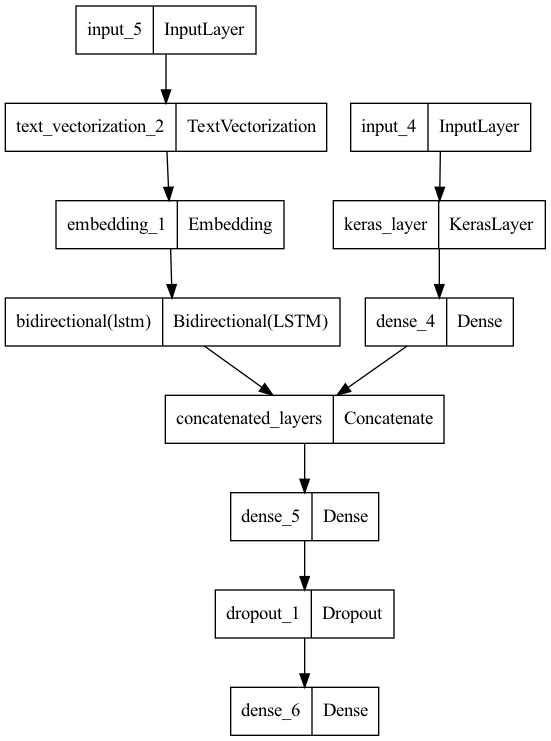

In [102]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [103]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.legacy.Adam(), 
                metrics=["accuracy"])
     

In [106]:
# Dataset
train_char_token=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
combined_train_dataset=tf.data.Dataset.zip((train_char_token,train_char_labels))

combined_train_dataset=combined_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token=tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_labels=tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
combined_val_dataset=tf.data.Dataset.zip((val_char_token,val_char_labels))

combined_val_dataset=combined_val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [107]:
combined_train_dataset,combined_val_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [108]:
model_4_history = model_4.fit(combined_train_dataset, 
                              steps_per_epoch=int(0.1 * len(combined_train_dataset)),
                              epochs=3,
                              validation_data=combined_val_dataset,
                              validation_steps=int(0.1 * len(combined_val_dataset)))

Epoch 1/3
562/562 [==============================] - 145s 249ms/step - loss: 0.9091 - accuracy: 0.6467 - val_loss: 0.7813 - val_accuracy: 0.6981
Epoch 2/3
562/562 [==============================] - 111s 198ms/step - loss: 0.7352 - accuracy: 0.7166 - val_loss: 0.6956 - val_accuracy: 0.7350
Epoch 3/3
562/562 [==============================] - 109s 194ms/step - loss: 0.7026 - accuracy: 0.7276 - val_loss: 0.6708 - val_accuracy: 0.7500


In [109]:
model_4_prob=model_4.predict(combined_val_dataset)

945/945 [==============================] - 135s 141ms/step


In [110]:
model_4_pred=tf.argmax(model_4_prob,axis=1)
model_4_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [111]:
model_4_results=calculate_results(val_labels_encoder,model_4_pred)
model_4_results

{'accuracy': 74.31815172779028,
 'precision': 74.56791634210045,
 'recall': 74.31815172779028,
 'F1-score': 74.33453044400244}

# Model_5 (Model_4 +Postional Embeddings: where the sentence appears in an abstract. )

In [112]:
train_df

target                                               text  \
0         OBJECTIVE  to investigate the efficacy of @ weeks of dail...   
1           METHODS  a total of @ patients with primary knee oa wer...   
2           METHODS  outcome measures included pain reduction and i...   
3           METHODS  pain was assessed using the visual analog pain...   
4           METHODS  secondary outcome measures included the wester...   
...             ...                                                ...   
180035      RESULTS  for the absolute change in percent atheroma vo...   
180036      RESULTS  for pav , a significantly greater percentage o...   
180037      RESULTS  both strategies had acceptable side effect pro...   
180038  CONCLUSIONS  compared with standard statin monotherapy , th...   
180039  CONCLUSIONS  ( plaque regression with cholesterol absorptio...   

        line_number  total_lines  
0                 0           11  
1                 1           11  
2                 2           11  
3                 3           11  
4                 4           11  
...             ...          ...  
180035            7           11  
180036            8           11  
180037            9           11  
180038           10           11  
180039           11           11  

[180040 rows x 4 columns]

<Axes: ylabel='Frequency'>

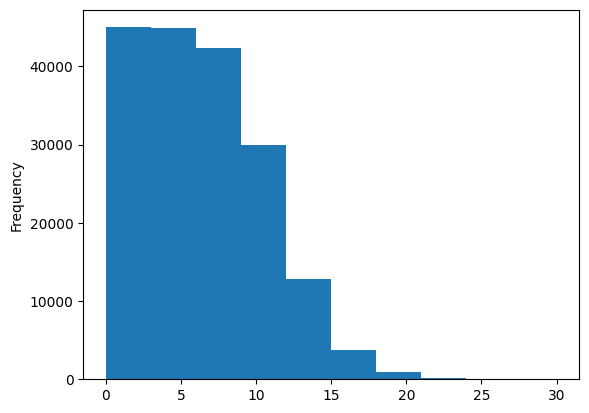

In [113]:
train_df.line_number.plot.hist()

In [114]:
np.percentile(train_df.line_number,98)

15.0

In [115]:
train_line_number_one_hot=tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_number_one_hot=tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_number_one_hot=tf.one_hot(test_df["line_number"].to_numpy(),depth=15)


In [116]:
train_line_number_one_hot[:10]

<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [117]:
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

In [118]:
np.percentile(train_df.total_lines,98)

20.0

In [119]:
train_total_lines=tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
valid_total_lines=tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines=tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)

In [120]:
train_total_lines[:5]

<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [121]:
# Token_input
token_inputs=tf.keras.layers.Input(shape=[],dtype="string")
embedding_layer=tf_hub_embedding_layer(token_inputs)
token_outputs=tf.keras.layers.Dense(128,activation="relu") (embedding_layer)
first_model=tf.keras.Model(token_inputs,token_outputs)

# Char_inputs

char_inputs=tf.keras.layers.Input(shape=(1,),dtype="string")
char_tokens=char_vectorization(char_inputs)
char_embedded=char_embedding(char_tokens)
char_outputs=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(char_embedded)
second_model=tf.keras.Model(char_inputs,char_outputs)

# Line Number 
line_number=tf.keras.layers.Input(shape=(15,), dtype=tf.int32)
x=tf.keras.layers.Dense(32,activation="relu")(line_number)
line_number_model=tf.keras.Model(line_number,x)

#total lines
total_lines_inputs = tf.keras.layers.Input(shape=(20,), dtype=tf.int32)
y = tf.keras.layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(total_lines_inputs,y)

combined_model=tf.keras.layers.Concatenate()([first_model.output,second_model.output])
z = tf.keras.layers.Dense(256, activation="relu")(combined_model)
z = tf.keras.layers.Dropout(0.5)(z)

z = tf.keras.layers.Concatenate()([line_number_model.output,total_line_model.output,z])
output_layer = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(z)


In [122]:
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 first_model.input, 
                                 second_model.input],
                                 outputs=output_layer)
     

In [123]:
model_5.summary()


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_2 (TextVect  (None, 290)         0           ['input_7[0][0]']                
 orization)                                                                                       
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['input_6[0][0]']         

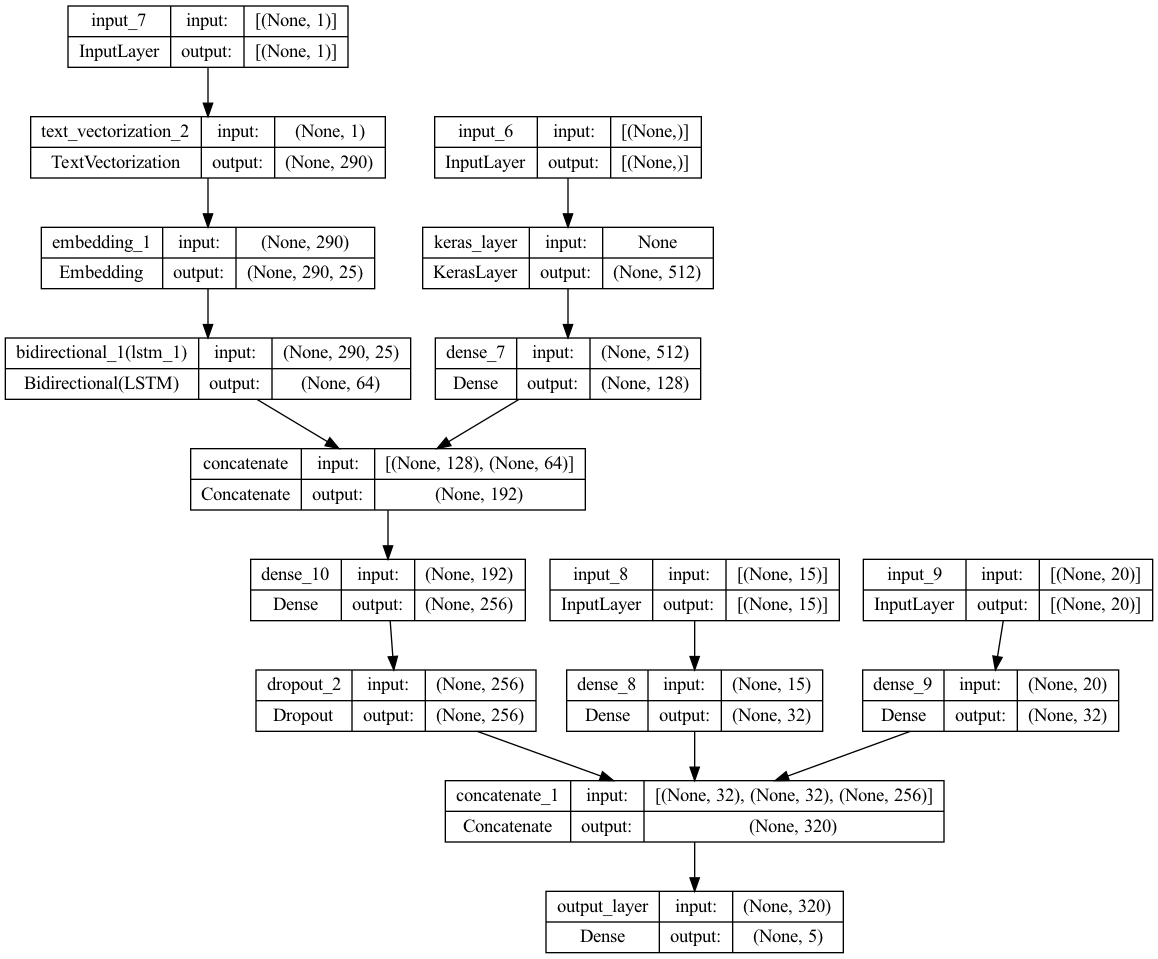

In [124]:
from tensorflow.keras.utils import plot_model
plot_model(model_5,show_shapes=True)

In [125]:
# label_smooting-prevents overfitting
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=["accuracy"])

In [126]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                                train_total_lines,
                                                                train_sentences,
                                                                train_chars)) 
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) 
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                              valid_total_lines,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [127]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 178s 306ms/step - loss: 1.0938 - accuracy: 0.7248 - val_loss: 0.9813 - val_accuracy: 0.8082
Epoch 2/3
562/562 [==============================] - 171s 305ms/step - loss: 0.9613 - accuracy: 0.8168 - val_loss: 0.9476 - val_accuracy: 0.8261
Epoch 3/3
562/562 [==============================] - 163s 290ms/step - loss: 0.9449 - accuracy: 0.8263 - val_loss: 0.9347 - val_accuracy: 0.8314


In [128]:
model_5_pred=model_5.predict(val_pos_char_token_dataset)

945/945 [==============================] - 225s 236ms/step


In [129]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred, axis=1)
model_5_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [130]:
model_5_results=calculate_results(val_labels_encoder,model_5_preds)

In [131]:
model_5_results

{'accuracy': 83.50655368727658,
 'precision': 83.40022533730422,
 'recall': 83.50655368727658,
 'F1-score': 83.35969828392814}

# Comparing Models

In [132]:
import pandas as pd
all_model_results=pd.DataFrame(
    { 
        "baseline":model_0_reults,
        "Model_1": model_1_results,
        "Model_2": model_2_results,
        "Model_3": model_3_results,
        "Model_4": model_4_results,
        "Model_5": model_5_results})

In [133]:
all_model_results=all_model_results.transpose()


In [134]:
all_model_results

accuracy  precision     recall   F1-score
baseline  72.183238  71.864670  72.183238  69.892504
Model_1   78.710446  78.333346  78.710446  78.413042
Model_2   71.392162  71.428237  71.392162  71.101595
Model_3   65.761949  65.443825  65.761949  64.577781
Model_4   74.318152  74.567916  74.318152  74.334530
Model_5   83.506554  83.400225  83.506554  83.359698

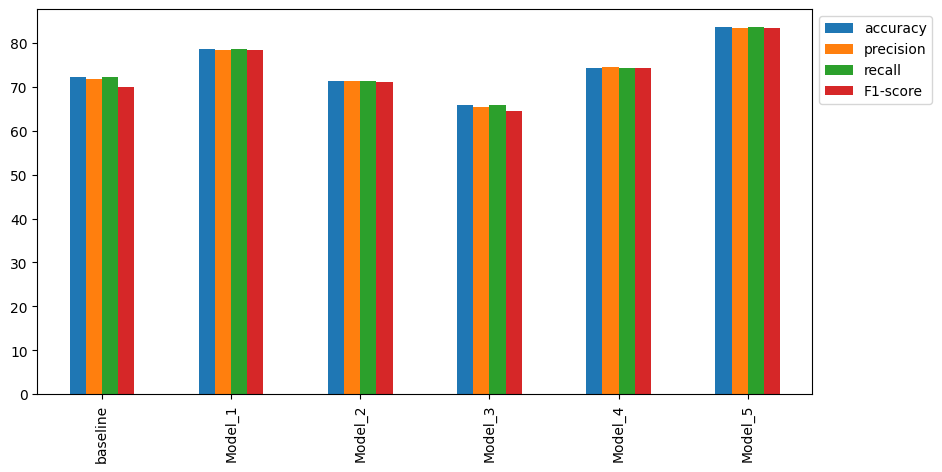

In [135]:
all_model_results.plot(kind="bar",figsize=(10,5)).legend(bbox_to_anchor=(1.0,1.0))

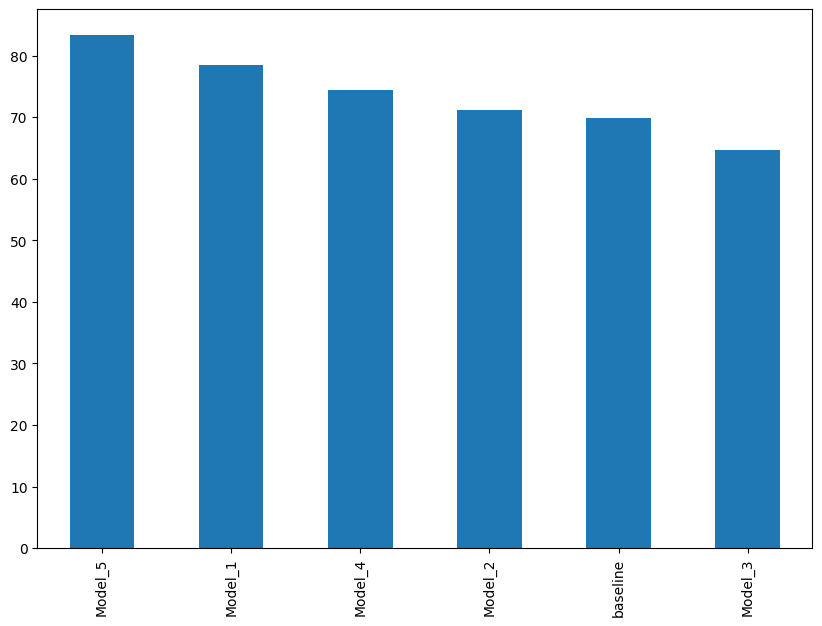

In [136]:
all_model_results.sort_values("F1-score", ascending=False)["F1-score"].plot(kind="bar", figsize=(10, 7));

In [137]:
model_5.save("skimlit_final_model") 

INFO:tensorflow:Assets written to: skimlit_final_model/assets


INFO:tensorflow:Assets written to: skimlit_final_model/assets


In [3]:
loaded_model=tf.keras.models.load_model("skimlit_final_model")

Metal device set to: Apple M2


2023-07-08 19:38:08.228766: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [27]:
import json
with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [29]:
from spacy.lang.en import English
nlp = English() 
sentencizer = nlp.add_pipe("sentencizer") 

doc = nlp(example_abstracts[0]["abstract"]) 
abstract_lines = [str(sent) for sent in list(doc.sents)] 
abstract_lines

/Users/ujjwalbansal/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [32]:
total_lines_in_sample = len(abstract_lines)

sample_lines = []
for i, line in enumerate(abstract_lines):
    sample_dict = {}
    sample_dict["text"] = str(line)
    sample_dict["line_number"] = i
    sample_dict["total_lines"] = total_lines_in_sample - 1
    sample_lines.append(sample_dict)
sample_lines


[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [33]:
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot


<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [34]:
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [37]:
def split_to_char(text):
    return " " .join(list(text))

In [38]:
abstract_chars = [split_to_char(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [40]:
# Make predictions on sample abstract features
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 2s 2s/step


array([[0.26708567, 0.09977566, 0.02257598, 0.5738482 , 0.03671453],
       [0.0666267 , 0.03083183, 0.71341974, 0.10463963, 0.08448218],
       [0.14207463, 0.06278381, 0.53325343, 0.1764009 , 0.08548719],
       [0.08821893, 0.13287878, 0.5818414 , 0.07643546, 0.12062543],
       [0.05683414, 0.11416066, 0.38816544, 0.04979956, 0.39104018],
       [0.03436745, 0.11669327, 0.5302272 , 0.04525217, 0.27345994],
       [0.02947308, 0.14869098, 0.08467548, 0.028472  , 0.7086885 ],
       [0.01927791, 0.1428847 , 0.27512696, 0.03265918, 0.5300512 ]],
      dtype=float32)

In [41]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 2, 4, 4])>

In [45]:
test_abstract_pred_classes = [labelencoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [47]:
for i, line in enumerate(abstract_lines):
    print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
